<a href="https://colab.research.google.com/github/JoshDumo/QuantumChem/blob/main/HH_QNature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install qiskit
!pip install qiskit_nature

In [8]:
!pip install pyscf

In [9]:
import numpy as np
import pylab
import copy
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit import Aer
from qiskit.algorithms import VQE, NumPyMinimumEigensolver


In [24]:
#molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
#molecule = Molecule(geometry=[['H', [0., 0., 0.]],
#                              ['H', [0., 0., 0.735]]],
#                     charge=0, multiplicity=1)

distances = np.arange(0.2, 1.5, 0.05)
vqe_energies = []
hf_energies = []
exact_energies = []

In [25]:
for i,d in enumerate(distances):
  print('step: ', i)
  molecule = Molecule(geometry=[['H', [0., 0., -d/2]],
                              ['H', [0., 0., d/2]]],
                     charge=0, multiplicity=1)
  driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
  problem = ElectronicStructureProblem(driver)

  second_q_ops = problem.second_q_ops()
  main_op = second_q_ops[0]

  num_particles = (problem.molecule_data_transformed.num_alpha,
                 problem.molecule_data_transformed.num_beta)
  num_spin_orbitals = 2 * problem.molecule_data.num_molecular_orbitals

  optimizer = L_BFGS_B()

  mapper = ParityMapper()
  converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
  
  # map to qubit operators
  qubit_op = converter.convert(main_op, num_particles=num_particles)

  init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

  ansatz = TwoLocal(num_spin_orbitals, ['ry', 'rz'], 'cz')

    #ansatz.draw()
  # add the initial state
  ansatz.compose(init_state, front=True)

  backend = Aer.get_backend('statevector_simulator')

  algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend)

  result = algorithm.compute_minimum_eigenvalue(qubit_op)
  #vqe_energies.append(result.eigenvalue.real)
  #print(result.eigenvalue.real)

  electronic_structure_result = problem.interpret(result)
  #print(electronic_structure_result.computed_energies)

  #exact results
  exact_algorithm = NumPyMinimumEigensolver()
  exact_result = exact_algorithm.compute_minimum_eigenvalue(qubit_op)
  exact_electronic_structure_result = problem.interpret(exact_result)
  print(exact_electronic_structure_result.total_energies[0])


  vqe_energies.append(electronic_structure_result.total_energies[0])
  hf_energies.append(electronic_structure_result.hartree_fock_energy)
  exact_energies.append(exact_electronic_structure_result.total_energies[0])


step:  0
0.15748213479836526
step:  1
-0.3122699027007907
step:  2
-0.6018037107656853
step:  3
-0.7892693924044141
step:  4
-0.914149704627081
step:  5
-0.9984155960160177
step:  6
-1.0551597944706246
step:  7
-1.0926299067451037
step:  8
-1.1162860068695413
step:  9
-1.1299047843229135
step:  10
-1.1361894540659239
step:  11
-1.1371170673457311
step:  12
-1.1341476666770958
step:  13
-1.1283618784581106
step:  14
-1.1205602812999875
step:  15
-1.1113394177361504
step:  16
-1.1011503302326173
step:  17
-1.0903421765127623
step:  18
-1.0791929449690736
step:  19
-1.0679296589128593
step:  20
-1.0567407463052583
step:  21
-1.0457831445498003
step:  22
-1.0351862664342548
step:  23
-1.0250543624687884
step:  24
-1.0154682492882454
step:  25
-1.0064869318291236


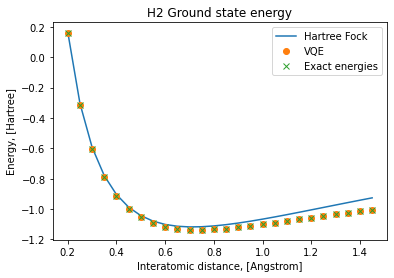

In [27]:
pylab.plot(distances,hf_energies,label='Hartree Fock')
pylab.plot(distances,vqe_energies,'o',label='VQE')
pylab.plot(distances,exact_energies,'x', label='Exact energies')

pylab.xlabel('Interatomic distance, [Angstrom]')
pylab.ylabel('Energy, [Hartree]')
pylab.title('H2 Ground state energy')
pylab.legend(loc='upper right')